# Treating cyclic peptides

In [32]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
import pandas as pd
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from rdkit.Chem import Fragments
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [33]:
import requests
import json
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Fragments

In [34]:
def mol2seq_cyclic(m):
    aa_smiles = {
        'ALA': 'C[C@H](N)C=O', 'CYS': 'N[C@H](C=O)CS', 'ASP': 'N[C@H](C=O)CC(=O)O',
        'GLU': 'N[C@H](C=O)CCC(=O)O', 'PHE': 'N[C@H](C=O)Cc1ccccc1', 'GLY': 'NCC=O',
        'HIS': 'N[C@H](C=O)Cc1c[nH]cn1', 'ILE': 'CC[C@H](C)[C@H](N)C=O', 'LYS': 'NCCCC[C@H](N)C=O',
        'LEU': 'CC(C)C[C@H](N)C=O', 'MET': 'CSCC[C@H](N)C=O', 'ASN': 'NC(=O)C[C@H](N)C=O',
        'PRO': 'O=C[C@@H]1CCCN1', 'GLN': 'NC(=O)CC[C@H](N)C=O', 'ARG': 'N=C(N)NCCC[C@H](N)C=O',
        'SER': 'N[C@H](C=O)CO', 'THR': 'C[C@@H](O)[C@H](N)C=O', 'VAL': 'CC(C)[C@H](N)C=O',
        'TRP': 'N[C@H](C=O)Cc1c[nH]c2ccccc12', 'TYR': 'N[C@H](C=O)Cc1ccc(O)cc1'
    }
    
    aas = ['GLY','ALA', 'VAL', 'CYS', 'ASP', 'GLU', 'PHE', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'TRP','TYR']
    
    # Detect the atoms of the backbone and assign them with info
    CAatoms = m.GetSubstructMatches(Chem.MolFromSmarts("[C:0](=[O:1])[C:2][N:3]"))
    for atoms in CAatoms:
        a = m.GetAtomWithIdx(atoms[2])
        info = Chem.AtomPDBResidueInfo()
        info.SetName(" CA ") # spaces are important
        a.SetMonomerInfo(info)
    
    # Detect the presence of residues and set residue name for CA atoms only
    aa_matches = {}
    for curr_aa in aas:
        matches = m.GetSubstructMatches(Chem.MolFromSmiles(aa_smiles[curr_aa]))
        aa_matches[curr_aa] = matches
        for atoms in matches:
            for atom in atoms:
                a = m.GetAtomWithIdx(atom)
                info = Chem.AtomPDBResidueInfo()
                if a.GetMonomerInfo() != None:
                    if a.GetMonomerInfo().GetName() == " CA ":
                        info.SetName(" CA ")
                        info.SetResidueName(curr_aa)
                        a.SetMonomerInfo(info)
    
    # Check if the peptide is cyclic
    N1 = Fragments.fr_amide(m)
    N2 = len(aa_matches['GLY'])
    is_cyclic = N2 == N1
    
    # Get the backbone atoms using a more robust SMARTS pattern
    backbone_smarts = "[NX3,NX4+][CX4H1][CX3](=[OX1])[NX3,NX4+]"
    backbone_matches = m.GetSubstructMatches(Chem.MolFromSmarts(backbone_smarts))
    
    if not backbone_matches:
        raise ValueError("Unable to identify peptide backbone")
    
    # Create a new atom order
    id_list = []
    for match in backbone_matches:
        id_list.extend(match[1:3])  # Add CA and C atoms
    
    if not is_cyclic:
        id_list.reverse()
    
    # Add non-backbone atoms to the list
    for idx in range(m.GetNumAtoms()):
        if idx not in id_list:
            id_list.append(idx)
    
    # Renumber atoms
    m_renum = Chem.RenumberAtoms(m, newOrder=id_list)
    
    return Chem.MolToSequence(m_renum)


# Example usage
mol = Chem.MolFromSmiles("CSCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](N)CC(=O)O)CSSC[C@@H](C(=O)N[C@@H](Cc2c[nH]c3ccccc23)C(=O)N[C@@H](CCC(N)=O)CN[C@@H](Cc2ccc(O)cc2)C(=O)O)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)CNC(=O)[C@H](CC(C)C)NC1=O")
print(mol2seq_cyclic(mol))

MCRLMDFDWCPRFVRLYG


In [35]:
def get_gpcr_info(entry_name):
    base_url = "https://gpcrdb.org"
    endpoint = f"/services/protein/{entry_name}/"
    
    try:
        # Make the GET request
        response = requests.get(base_url + endpoint)
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            
            # Extract relevant information
            protein_info = {
                "entry_name": data.get('entry_name'),
                "name": data.get('name'),
                "accession": data.get('accession'),
                "family": data.get('family'),
                "sequence": data.get('sequence'),
                "species": data.get('species')
            }
            
            return protein_info
        else:
            return f"Error: {response.status_code} - {response.text}"
    
    except requests.exceptions.RequestException as e:
        return f"Error: {str(e)}"


In [36]:
entry_name = "mchr1_human"  
protein_info = get_gpcr_info(entry_name)

if isinstance(protein_info, dict):
    print(json.dumps(protein_info, indent=2))
else:
    print(protein_info)  

{
  "entry_name": "mchr1_human",
  "name": "MCH<sub>1</sub> receptor",
  "accession": "Q99705",
  "family": "001_002_013_001",
  "sequence": "MSVGAMKKGVGRAVGLGGGSGCQATEEDPLPNCGACAPGQGGRRWRLPQPAWVEGSSARLWEQATGTGWMDLEASLLPTGPNASNTSDGPDNLTSAGSPPRTGSISYINIIMPSVFGTICLLGIIGNSTVIFAVVKKSKLHWCNNVPDIFIINLSVVDLLFLLGMPFMIHQLMGNGVWHFGETMCTLITAMDANSQFTSTYILTAMAIDRYLATVHPISSTKFRKPSVATLVICLLWALSFISITPVWLYARLIPFPGGAVGCGIRLPNPDTDLYWFTLYQFFLAFALPFVVITAAYVRILQRMTSSVAPASQRSIRLRTKRVTRTAIAICLVFFVCWAPYYVLQLTQLSISRPTLTFVYLYNAAISLGYANSCLNPFVYIVLCETFRKRLVLSVKPAAQGQLRAVSNAQTADEERTESKGT",
  "species": "Homo sapiens"
}


In [37]:
def get_pdb_sequence(pdb_id):
    url = f"https://www.rcsb.org/fasta/entry/{pdb_id}/display"
    response = requests.get(url)
    if response.status_code == 200:
        sequences = response.text.split('>')[1:]  # Split by '>' and remove the first empty element
        for seq in sequences:
            header, sequence = seq.split('\n', 1)
            sequence = sequence.replace('\n', '')
            print(f">{header}")
            print(sequence)
    else:
        print(f"Failed to retrieve sequence for {pdb_id}")

In [38]:
pdb_id = "8WSS"
get_pdb_sequence(pdb_id)

>8WSS_2|Chain B|Guanine nucleotide-binding protein G(I)/G(S)/G(T) subunit beta-1|Homo sapiens (9606)
MHHHHHHGSLLQSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRTRRTLRGHLAKIYAMHWGTDSRLLVSASQDGKLIIWDSYTTNKVHAIPLRSSWVMTCAYAPSGNYVACGGLDNICSIYNLKTREGNVRVSRELAGHTGYLSCCRFLDDNQIVTSSGDTTCALWDIETGQQTTTFTGHTGDVMSLSLAPDTRLFVSGACDASAKLWDVREGMCRQTFTGHESDINAICFFPNGNAFATGSDDATCRLFDLRADQELMTYSHDNIICGITSVSFSKSGRLLLAGYDDFNCNVWDALKADRAGVLAGHDNRVSCLGVTDDGMAVATGSWDSFLKIWNGSSGGGGSGGGGSSGVSGWRLFKKIS
>8WSS_5|Chain E[auth L]|Pro-MCH|Homo sapiens (9606)
DFDMLRCMLGRVYRPCWQV
>8WSS_6|Chain F[auth R]|Melanin-concentrating hormone receptor 1|Homo sapiens (9606)
QGGTMDLEASLLPTGPNASNTSDGPDNLTSAGSPPRTGSISYINIIMPSVFGTICLLGIIGNSTVIFAVVKKSKLHWCNNVPDIFIINLSVVDLLFLLGMPFMIHQLMGNGVWHFGETMCTLITAMDANSQFTSTYILTAMAIDRYLATVHPISSTKFRKPSVATLVICLLWALSFISITPVWLYARLIPFPGGAVGCGIRLPNPDTDLYWFTLYQFFLAFALPFVVITAAYVRILQRMTSSVAPASQRSIRLRTKRVTRTAIAICLVFFVCWAPYYVLQLTQLSISRPTLTFVYLYNAAISLGYANSCLNPFVYIVLCETFRKRLVLSVKPAAQGQLRAGSSGGGGSGGGGSSGVFTLEDFVG

# Target Chains: Chain F (MCHR1) + Chain E (MCH)

# Alfa Fold 3 results:

In [21]:
df = pd.read_json('/home/elly/programming/cache5/cyclic_peptide/fold_mchr1/fold_mchr1_summary_confidences_0.json')

In [22]:
df

,chain_iptm,chain_pair_iptm,chain_pair_pae_min,chain_ptm,fraction_disordered,has_clash,iptm,num_recycles,ptm,ranking_score
0,0.54,"[0.65, 0.54]","[0.76, 4.53]",0.65,0.32,0,0.54,10,0.65,0.72
1,0.54,"[0.54, 0.01]","[7.32, 0.76]",0.01,0.32,0,0.54,10,0.65,0.72


### Alpha Fold 3 model:

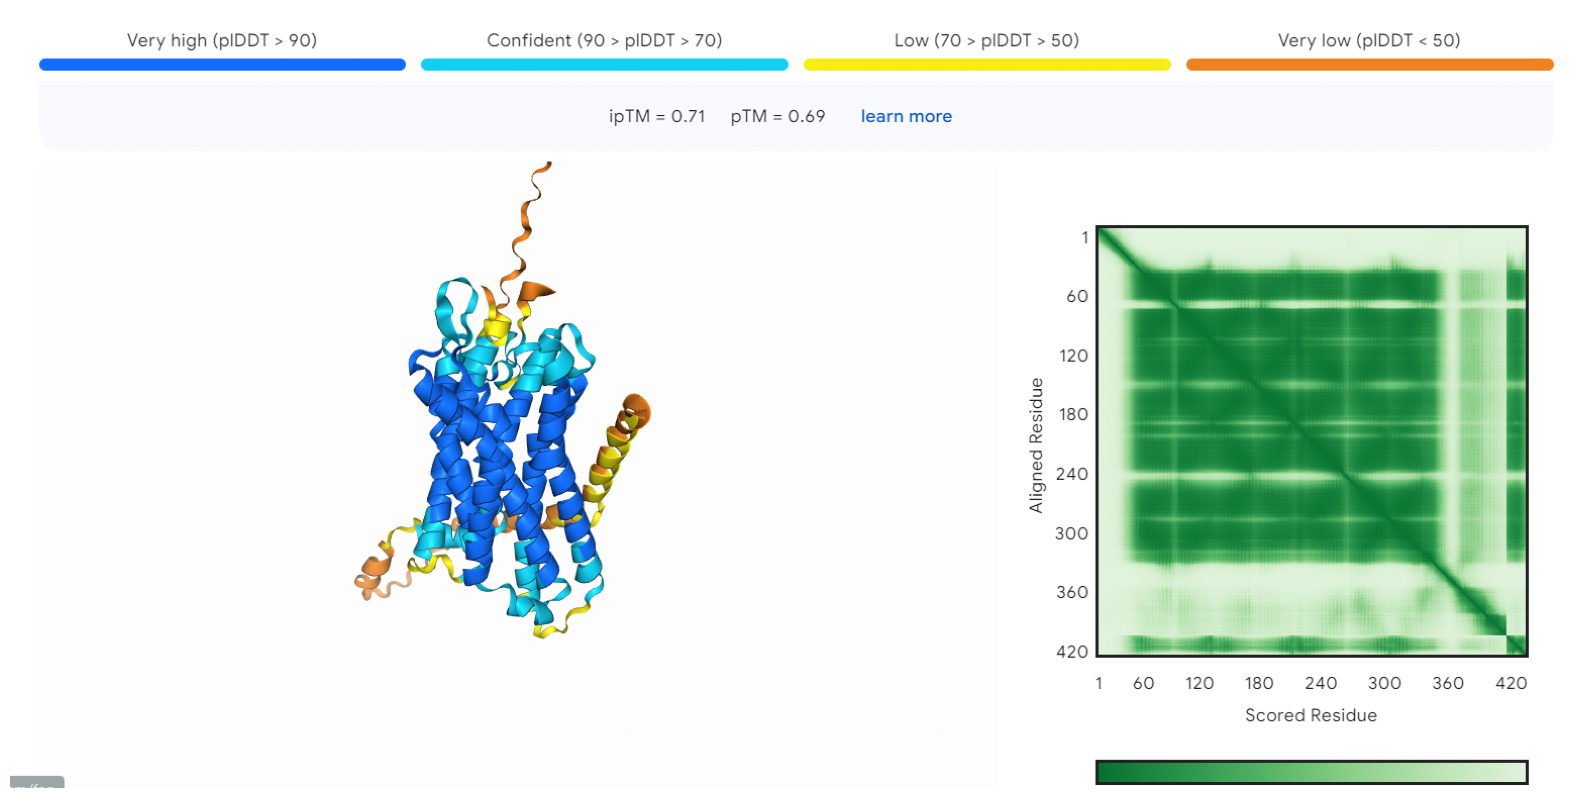

In [24]:
plt.figure(figsize=(20, 16))
img = mpimg.imread("/home/elly/programming/cache5/cyclic_peptide/fold_mchr1/model_8wss.png")
plt.imshow(img)
plt.axis('off') 
plt.show()

### Cryo_EM structure (lila) and Alpha Fold 3 model (yellow):

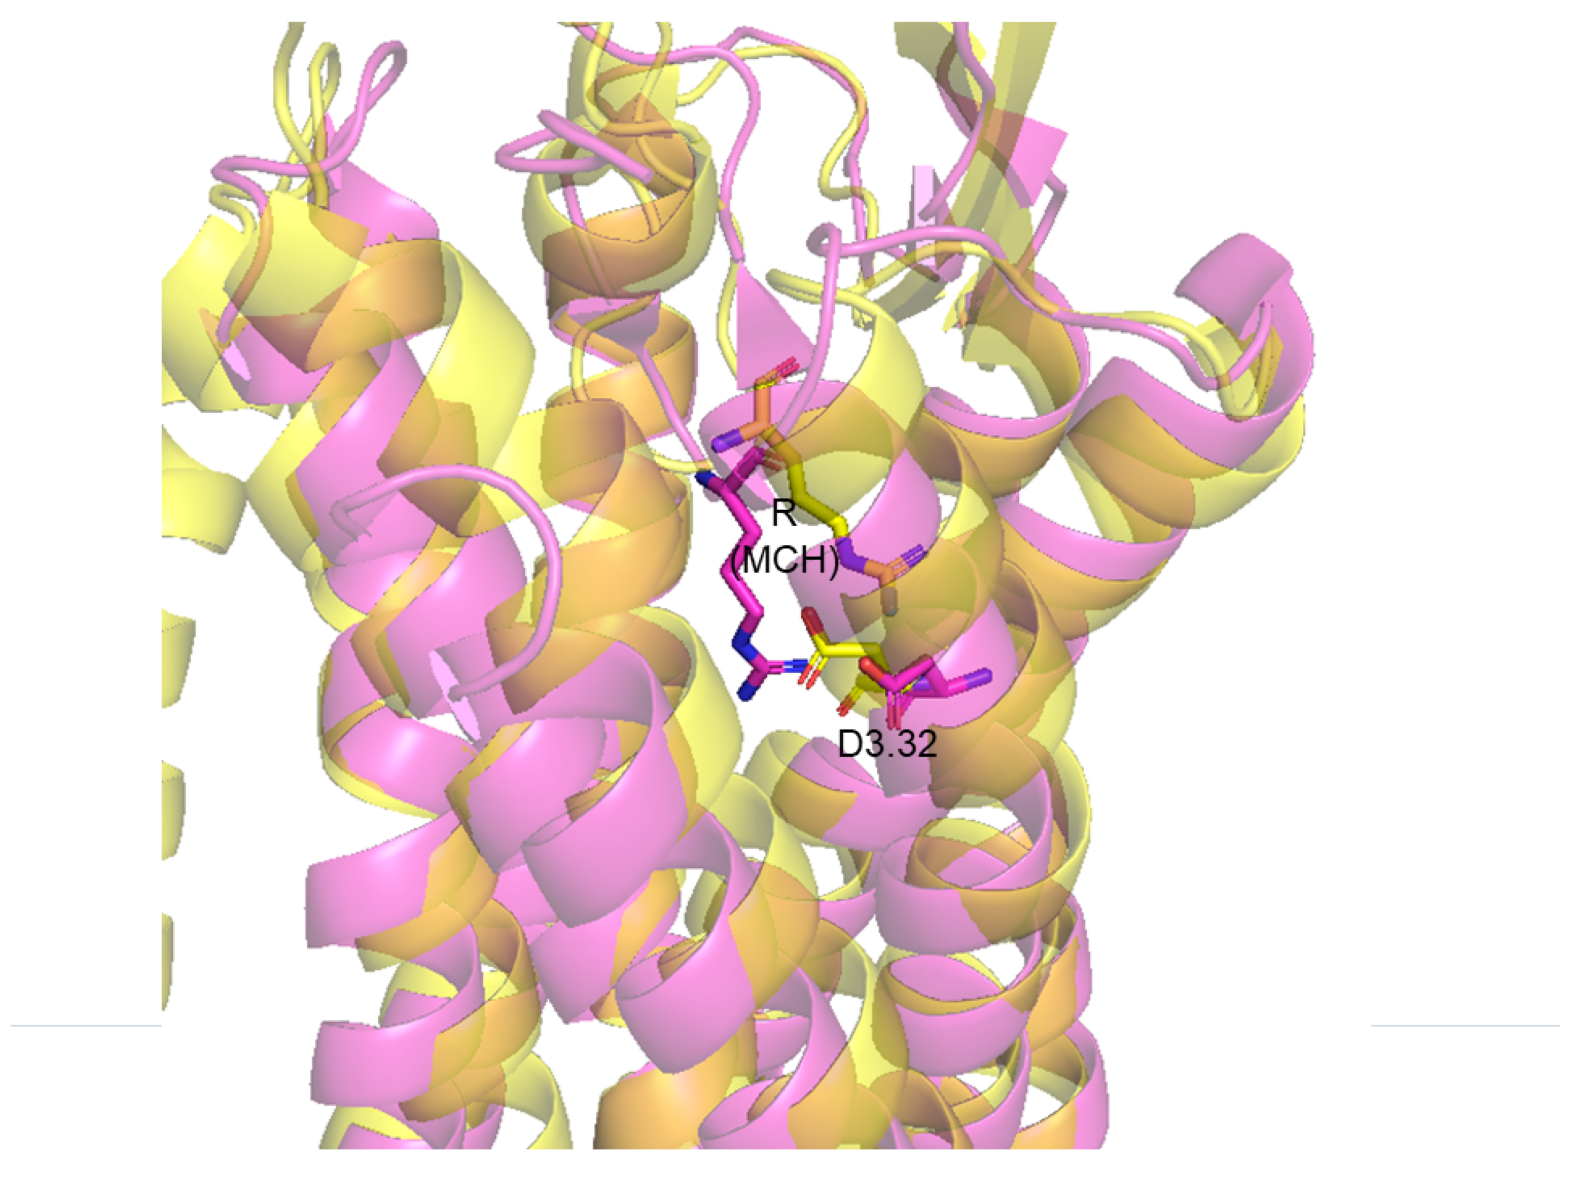

In [31]:
plt.figure(figsize=(20, 16))
img = mpimg.imread("/home/elly/programming/cache5/cyclic_peptide/fold_mchr1/Modelled.png")
plt.imshow(img)
plt.axis('off')
plt.show()